# Machine Learning

So this is a peripheral topic relative to most of the concepts we've studied so far this semester, but it's an increasingly important area of computational technology and it's important to be aware of emerging tools in case they might be useful for a problem you encounter in your work. The idea is to create mechanisms for a machine (computer) to "learn" from data. A common example is the "movie rating" system in which a user rates a bunch of movies they like (or don't like). The machine learning algorithm uses these user ratings, along with many other users' ratings to predict which unwatched movies this new user would prefer to watch.



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [29]:
df = pd.read_csv('Iris.csv')

In [31]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


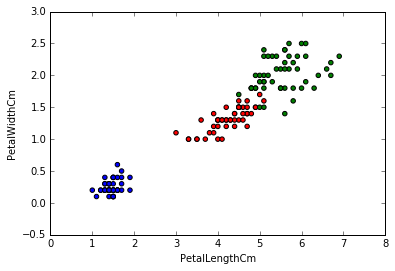

In [39]:
cdict = {'Iris-setosa':'b', 'Iris-virginica':'g'}
df.plot.scatter('PetalLengthCm','PetalWidthCm',c=df['Species'].apply(lambda x: cdict.get(x,'r')))